In [1]:
%pip install gpytorch;

Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import numpy as np
import math
import torch
import gpytorch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Make a toy dataset

In [3]:
x_lin = np.linspace(-3, 3, 100)
y_lin = np.linspace(-3, 3, 100)

grid  = np.array(np.meshgrid(x_lin, y_lin))
print(grid.shape)

(2, 100, 100)


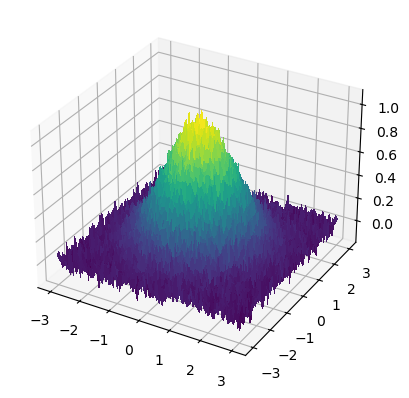

In [4]:
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise):
    z = torch.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return z + torch.normal(size=tuple(z.shape), mean=0.0, std=noise)

def make_test_dataset(size, bounds, x0, y0, sigma_x, sigma_y, noise):
    x = np.linspace(bounds[0], bounds[1], size)
    y = np.linspace(bounds[0], bounds[1], size)

    grid = torch.from_numpy(np.stack([x, y], axis=-1))
    xy = gpytorch.utils.grid.create_data_from_grid(grid)

    z = gaussian_2d(xy[:, 0], xy[:, 1], x0, y0, sigma_x, sigma_y, noise)

    return grid.double(), xy.double(), z.double()

size = 100
grid, xy, z = make_test_dataset(size, (-3, 3), 0, 0, 1, 1, 0.05)

# Plot the surface
shape = (size, size)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(
    xy[:, 0].numpy().reshape(shape), 
    xy[:, 1].numpy().reshape(shape), 
    z.numpy().reshape(shape), cmap="viridis",
    linewidth=0, antialiased=False)

plt.show()

## Compute empirical variogram

In [5]:
x_sample = xy[:, 0].numpy().flatten()
y_sample = xy[:, 1].numpy().flatten()
z_sample = z.numpy()

# Shuffle to create point pairs - this isn't all pairs but
# should be a reasonable approximation
shuffled = np.stack([x_sample, y_sample, z_sample], axis=-1)
np.random.shuffle(shuffled)
x_shuffle = shuffled[:, 0]
y_shuffle = shuffled[:, 1]
z_shuffle = shuffled[:, 2]

d  = ((x_sample - x_shuffle)**2 + (y_sample - y_shuffle)**2)**0.5
dz = (z_sample - z_shuffle)**2

sum_d, edges  = np.histogram(d, weights=dz, bins=100)
n_d, edges = np.histogram(d, bins=100)
mean_d = sum_d / (n_d+1) # prevent division by zero

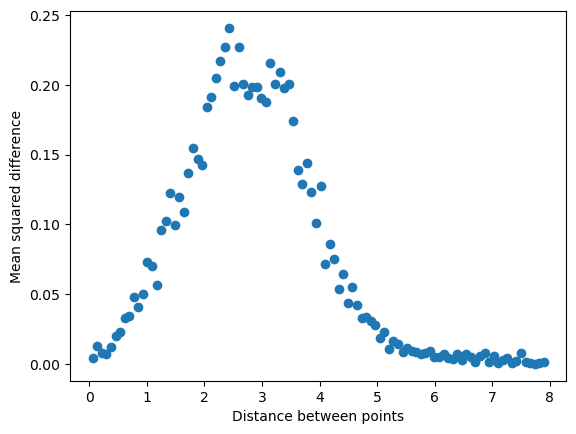

In [6]:
plt.scatter(edges[:-1], mean_d)
plt.ylabel("Mean squared difference")
plt.xlabel("Distance between points")
plt.show()

This is a very idealized case where a Matern kernel should work well.

## Training functions

In [7]:
import time
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Gpytorch versions
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModelGrid(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(ExactGPModelGrid, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.MaternKernel(), grid=grid)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gpytorch_model(xy_tensor, z_tensor, use_structure=False, use_gpu=False, n_iter=10, grid=None):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    if use_structure:
        model = ExactGPModelGrid(grid, xy_tensor, z_tensor, likelihood)
    else:
        model = ExactGPModel(xy_tensor, z_tensor, likelihood)

    if use_gpu:
        xy_tensor = xy_tensor.cuda()
        z_tensor = z_tensor.cuda()
        model = model.cuda()    
        likelihood = likelihood.cuda()
    else:
        xy_tensor = xy_tensor.cpu()
        z_tensor = z_tensor.cpu()
        model = model.cpu()
        likelihood = likelihood.cpu()

    # Transition to train mode
    model.train()
    likelihood.train()

    # Set up optimizter and log-likelihood
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    t0 = time.time()
    for _ in tqdm(range(n_iter)):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(xy_tensor)
        # Calc loss and backprop gradients
        loss = -mll(output, z_tensor)
        loss.backward()
    tf = time.time()
    elapsed = tf - t0

    return model, likelihood, elapsed

# Too slow!

#def train_scikit_model(xy_arr, z_arr, n_iter=10):
#    kernel = Matern(length_scale=4.0, nu=2.5)
#    
#    # n_restarts = 0 implies 1 run
#    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_iter-1,
#                                               optimizer="adam")
#    gaussian_process.fit(xy_arr, z_arr)
#    return gaussian_process



Verify that all the models successfully train.

In [9]:
model1 = train_gpytorch_model(xy, z)

100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


In [10]:
model2 = train_gpytorch_model(xy, z, use_gpu=True)

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


In [11]:
model3 = train_gpytorch_model(xy, z, use_structure=True, grid=grid)

100%|██████████| 10/10 [00:00<00:00, 62.89it/s]


In [12]:
model4 = train_gpytorch_model(xy, z, use_structure=True, use_gpu=True, grid=grid)

100%|██████████| 10/10 [00:00<00:00, 32.96it/s]


## Benchmark on different dataset sizes

In [13]:
sizes = [10, 50, 100]
t_result = []
mse_result = []

for s in sizes:
    print("Size: {}".format(s))
    grid, xy, z = make_test_dataset(s, (-3, 3), 0, 0, 1, 1, 0.05)
    
    is_train = torch.rand(size=(xy.shape[0],)) > 0.8

    xy_train = xy[is_train, :]
    z_train  =  z[is_train]

    xy_test  = xy[~is_train, :]
    z_test   =  z[~is_train]
    
    # Fit everything, making sure we get timings
    m1, l1, t1 = train_gpytorch_model(xy_train, z_train)
    
    m2, l2, t2 = train_gpytorch_model(xy_train, z_train, 
                                      use_gpu=True)
    
    m3, l3, t3 = train_gpytorch_model(xy_train, z_train, 
                                      use_structure=True, grid=grid)
    
    m4, l4, t4 = train_gpytorch_model(xy_train, z_train, 
                                      use_gpu=True, use_structure=True, grid=grid)

    t_result.append([t1, t2, t3, t4])
    
    # Compute test performance
    with torch.no_grad(), gpytorch.settings.fast_pred_samples():
        mse_vec = []
        for (m, l) in [(m1, l1), (m2, l2), (m3, l3), (m4, l4)]:
            m.eval()
            l.eval()
            m.cpu()
            l.cpu()
            pred = l(m(xy_test))
            mse = np.mean((pred.mean.numpy() - z_test.numpy()) ** 2)
            mse_vec.append(mse)
        
    mse_result.append(mse_vec)

Size: 10


100%|██████████| 10/10 [00:00<00:00, 345.98it/s]


Size: 50


100%|██████████| 10/10 [00:00<00:00, 114.38it/s]


Size: 100


100%|██████████| 10/10 [00:00<00:00, 11.50it/s]


In [14]:
import pandas as pd

In [15]:
t_df = pd.DataFrame(
    t_result, 
    columns=["No structure, CPU", "No structure, GPU", "Structural kernel, CPU", "Structural kernel, GPU"]
)
t_df["Size"] = [s * s for s in sizes]

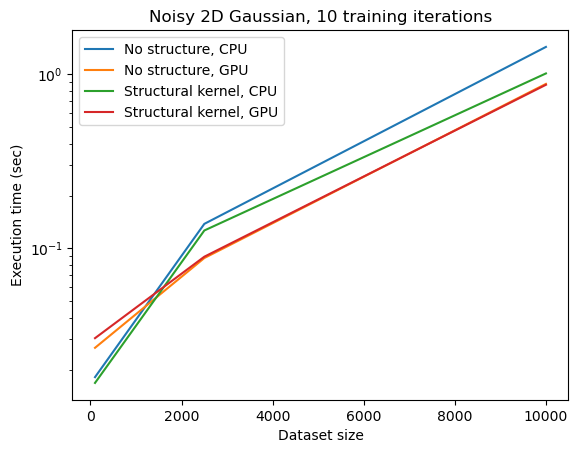

In [16]:
t_df.plot(x="Size")
plt.xlabel("Dataset size")
plt.ylabel("Execution time (sec)")
plt.title("Noisy 2D Gaussian, 10 training iterations")
plt.yscale("log")
plt.show()

In [17]:
m_df = pd.DataFrame(
    mse_result, 
    columns=["No structure, CPU", "No structure, GPU", "Structural kernel, CPU", "Structural kernel, GPU"]
)
m_df["Size"] = [s * s for s in sizes]

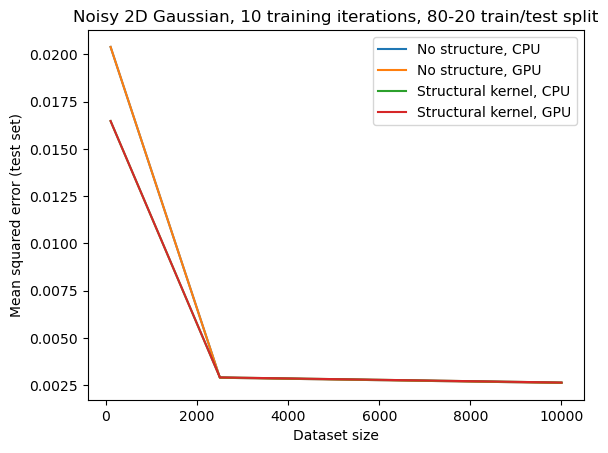

In [18]:
m_df.plot(x="Size")
plt.xlabel("Dataset size")
plt.ylabel("Mean squared error (test set)")
plt.title("Noisy 2D Gaussian, 10 training iterations, 80-20 train/test split")
plt.show()